In [ ]:
!pip install timm

In [1]:
import torch
import timm
import scipy

from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10,CIFAR100,Food101
from torchvision.transforms import Compose, ToTensor, Normalize
import os
import random
from itertools import permutations

import torch
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

In [2]:
# Define our own plot function
def scatter(x, labels, root='plot', subtitle=None, idx2name=None):
    
    num_classes = len(idx2name) # Calculate the number of classes
    palette = np.array(sns.color_palette("hls", num_classes)) # Choosing color

    ## Create a seaborn scatter plot ##
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int32)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    ## ---------------------------- ##
    
        
    txts = []
    for i in range(num_classes):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, idx2name[i], fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)        
        
    ## ---------------------------- ##    
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    if not os.path.exists(root):
        os.makedirs(root)        
    plt.savefig(os.path.join(root, str(subtitle)))

In [3]:
tsne = TSNE(random_state=0)

In [4]:
train_loader = DataLoader(CIFAR10('./CIFAR10/', train=True, download=True,
                                transform=Compose([ToTensor(),Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                               ),batch_size=128, shuffle=True,num_workers=0)
test_loader = DataLoader(CIFAR10('./CIFAR10/', train=False, download=True,
                                transform=Compose([ToTensor(),Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                               ),batch_size=128, shuffle=False,num_workers=0,)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
x_test, y_test = next(iter(test_loader))
x_test = x_test.flatten(1).detach().numpy()
y_test = y_test.detach().numpy()

In [6]:
x_train, y_train = next(iter(train_loader))
x_train = x_train.flatten(1).detach().numpy()
y_train = y_train.detach().numpy()

In [7]:
train_tsne_embeds = tsne.fit_transform(x_train)
test_tsne_embeds = tsne.fit_transform(x_test)

/home/theator/.pyenv/versions/3.8.12/envs/research38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/theator/.pyenv/versions/3.8.12/envs/research38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/theator/.pyenv/versions/3.8.12/envs/research38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/theator/.pyenv/versions/3.8.12/envs/research38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [8]:
idx2name=train_loader.dataset.classes

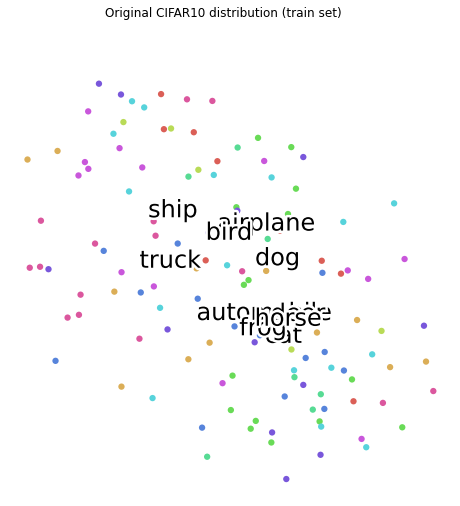

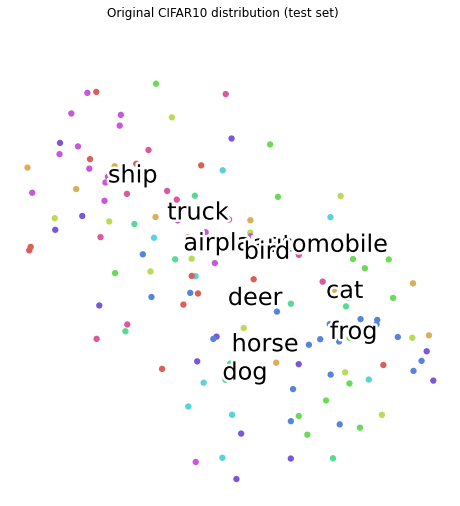

In [9]:
scatter(train_tsne_embeds, y_train, subtitle=f'Original CIFAR10 distribution (train set)', idx2name=idx2name)
scatter(test_tsne_embeds, y_test, subtitle=f'Original CIFAR10 distribution (test set)', idx2name=idx2name)

In [10]:

device = torch.device("cuda:1")

batch_size_train = 256
batch_size_vis = 128
num_workers = 5

In [11]:
import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_loader = DataLoader(CIFAR10('./CIFAR10/', train=True, download=True,
                                transform=transform_train
                               ),batch_size=batch_size_train, shuffle=True,num_workers=num_workers,)
test_loader = DataLoader(CIFAR10('./CIFAR10/', train=False, download=True,
                                transform=transform_test
                               ),batch_size=batch_size_train, shuffle=False,num_workers=num_workers)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
import torch
import torch.nn as nn

class CenterLoss(nn.Module):
    """Center loss.
    
    Reference:
    Wen et al. A Discriminative Feature Learning Approach for Deep Face Recognition. ECCV 2016.
    
    Args:
        num_classes (int): number of classes.
        feat_dim (int): feature dimension.
    """
    def __init__(self, num_classes=10, feat_dim=2, use_gpu=True):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.use_gpu = use_gpu
        if torch.backends.mps.is_available():
            self.device = torch.device("mps")
        elif torch.cuda.is_available():
            self.device = torch.device("cuda:1")
            
        if self.use_gpu:

            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).to(self.device))
        else:
            self.device = torch.device("cpu")
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim))

    def forward(self, x, labels):
        """
        Args:
            x: feature matrix with shape (batch_size, feat_dim).
            labels: ground truth labels with shape (batch_size).
        """
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(1, -2, x, self.centers.t())

        classes = torch.arange(self.num_classes).long()
        if self.use_gpu: classes = classes.to(self.device)
        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = distmat * mask.float()
        loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size

        return loss

In [23]:
num_classes = 10
epochs = 300
alpha = 0.5

lr_cent = 0.5
lr = 0.05

model = timm.create_model('resnet18',num_classes=0, pretrained=False)
model.conv1 = torch.nn.Conv2d(3,64, kernel_size=(3,3),stride=(1,1),padding=(1,1),bias=False)
model.maxpool = nn.Identity()
classifier = torch.nn.Linear(512,num_classes)

model = model.to(device)
classifier = classifier.to(device)


criterion_xent = nn.CrossEntropyLoss()
criterion_cent = CenterLoss(num_classes=num_classes, feat_dim=512, use_gpu=True)

optimizer_centloss = torch.optim.SGD(criterion_cent.parameters(), lr=lr_cent)
params = list(model.parameters()) + list(classifier.parameters()) 
optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=5e-4) # here lr is the overall learning rate
iter_per_epoch = len(train_loader)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                lr,
                epochs=epochs,
                steps_per_epoch=iter_per_epoch,
            )

scheduler_center_loss = torch.optim.lr_scheduler.OneCycleLR(
                optimizer_centloss,
                lr_cent,
                epochs=epochs,
                steps_per_epoch=iter_per_epoch,
            )


In [24]:
for epoch in range(epochs):  # loop over the dataset multiple times

    running_center_loss_loss = 0.0
    running_cross_loss_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        optimizer_centloss.zero_grad()
        # forward + backward + optimize
        features = model(inputs)
        outputs = classifier(features)
        cross_loss = criterion_xent(outputs, labels)
        center_loss = criterion_cent(features, labels) * alpha 
        loss = cross_loss + center_loss
        
        
        optimizer.zero_grad()
        optimizer_centloss.zero_grad()

        loss.backward()

        # multiple (1./alpha) in order to remove the effect of alpha on updating centers
        for param in criterion_cent.parameters():
            param.grad.data *= (1./alpha)

        optimizer_centloss.step()
        optimizer.step()
        
        scheduler.step()
        #scheduler_center_loss.step()
        
        running_center_loss_loss += center_loss.item()
        running_cross_loss_loss += cross_loss.item()
        


    train_epoch_loss_center = running_center_loss_loss / len(train_loader)
    train_epoch_loss_cls = running_cross_loss_loss / len(train_loader)

    running_center_loss_loss = 0.0
    running_cross_loss_loss = 0.0
    acc = 0.0
    model.eval()
    for i, data in enumerate(test_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        features = model(inputs)
        outputs = classifier(features)


        cross_loss = criterion_xent(outputs, labels)
        center_loss = criterion_cent(features, labels) * alpha 
        loss = cross_loss + center_loss
        acc += (outputs.softmax(dim=1).max(dim=1)[1] == labels).sum().item()
        
        running_center_loss_loss += center_loss.item()
        running_cross_loss_loss += cross_loss.item()
    eval_cls_loss = running_cross_loss_loss / len(test_loader)
    print(acc / len(test_loader.dataset))
    eval_central_loss = running_center_loss_loss / len(test_loader)
    
    
    print(f"At epoches = {epoch}, ")
    print(f"train_epoch_loss_cls = {train_epoch_loss_cls:.6f}, train_epoch_loss_center = {train_epoch_loss_center:.6f}")
    print(f"eval_cls_loss = {eval_cls_loss:.6f}, eval_central_loss = {eval_central_loss:.6f}")

print('Finished Training')

26.85
At epoches = 0, 
train_epoch_loss_cls = 2.300296, train_epoch_loss_center = 23.466551
eval_cls_loss = 2.299659, eval_central_loss = 1.803728
31.35
At epoches = 1, 
train_epoch_loss_cls = 2.295830, train_epoch_loss_center = 0.160523
eval_cls_loss = 2.293462, eval_central_loss = 0.474451
48.1
At epoches = 2, 
train_epoch_loss_cls = 2.294819, train_epoch_loss_center = 0.054322
eval_cls_loss = 2.290783, eval_central_loss = 0.210475
41.425
At epoches = 3, 
train_epoch_loss_cls = 2.291626, train_epoch_loss_center = 0.031956
eval_cls_loss = 2.285612, eval_central_loss = 0.104479
44.525
At epoches = 4, 
train_epoch_loss_cls = 2.285255, train_epoch_loss_center = 0.024514
eval_cls_loss = 2.274100, eval_central_loss = 0.066755
41.475
At epoches = 5, 
train_epoch_loss_cls = 2.267777, train_epoch_loss_center = 0.026588
eval_cls_loss = 2.242846, eval_central_loss = 0.061151
50.675
At epoches = 6, 
train_epoch_loss_cls = 2.224961, train_epoch_loss_center = 0.041393
eval_cls_loss = 2.169665, eva

215.825
At epoches = 56, 
train_epoch_loss_cls = 0.358417, train_epoch_loss_center = 0.074651
eval_cls_loss = 0.441343, eval_central_loss = 0.093950
210.075
At epoches = 57, 
train_epoch_loss_cls = 0.354535, train_epoch_loss_center = 0.073729
eval_cls_loss = 0.515844, eval_central_loss = 0.105514
214.25
At epoches = 58, 
train_epoch_loss_cls = 0.350311, train_epoch_loss_center = 0.073224
eval_cls_loss = 0.452211, eval_central_loss = 0.096585
214.425
At epoches = 59, 
train_epoch_loss_cls = 0.339994, train_epoch_loss_center = 0.073030
eval_cls_loss = 0.449583, eval_central_loss = 0.092383
216.65
At epoches = 60, 
train_epoch_loss_cls = 0.346016, train_epoch_loss_center = 0.073191
eval_cls_loss = 0.422003, eval_central_loss = 0.088184
220.175
At epoches = 61, 
train_epoch_loss_cls = 0.338439, train_epoch_loss_center = 0.072213
eval_cls_loss = 0.378927, eval_central_loss = 0.077289
221.875
At epoches = 62, 
train_epoch_loss_cls = 0.328714, train_epoch_loss_center = 0.071203
eval_cls_loss 

225.65
At epoches = 112, 
train_epoch_loss_cls = 0.206837, train_epoch_loss_center = 0.059045
eval_cls_loss = 0.326451, eval_central_loss = 0.090279
220.725
At epoches = 113, 
train_epoch_loss_cls = 0.203121, train_epoch_loss_center = 0.058974
eval_cls_loss = 0.395476, eval_central_loss = 0.101915
220.65
At epoches = 114, 
train_epoch_loss_cls = 0.202270, train_epoch_loss_center = 0.059308
eval_cls_loss = 0.413535, eval_central_loss = 0.096182
224.775
At epoches = 115, 
train_epoch_loss_cls = 0.205358, train_epoch_loss_center = 0.059515
eval_cls_loss = 0.332956, eval_central_loss = 0.084960
226.425
At epoches = 116, 
train_epoch_loss_cls = 0.204761, train_epoch_loss_center = 0.059303
eval_cls_loss = 0.302335, eval_central_loss = 0.087304
226.475
At epoches = 117, 
train_epoch_loss_cls = 0.204041, train_epoch_loss_center = 0.059667
eval_cls_loss = 0.316360, eval_central_loss = 0.083993
224.05
At epoches = 118, 
train_epoch_loss_cls = 0.204791, train_epoch_loss_center = 0.059864
eval_cls

223.325
At epoches = 167, 
train_epoch_loss_cls = 0.158165, train_epoch_loss_center = 0.054754
eval_cls_loss = 0.358774, eval_central_loss = 0.102022
223.8
At epoches = 168, 
train_epoch_loss_cls = 0.153145, train_epoch_loss_center = 0.053867
eval_cls_loss = 0.367396, eval_central_loss = 0.114566
228.5
At epoches = 169, 
train_epoch_loss_cls = 0.145878, train_epoch_loss_center = 0.051511
eval_cls_loss = 0.301456, eval_central_loss = 0.089378
227.375
At epoches = 170, 
train_epoch_loss_cls = 0.154301, train_epoch_loss_center = 0.053923
eval_cls_loss = 0.306671, eval_central_loss = 0.089139
225.6
At epoches = 171, 
train_epoch_loss_cls = 0.144390, train_epoch_loss_center = 0.052008
eval_cls_loss = 0.338460, eval_central_loss = 0.107592
225.225
At epoches = 172, 
train_epoch_loss_cls = 0.149089, train_epoch_loss_center = 0.052115
eval_cls_loss = 0.338738, eval_central_loss = 0.099517
227.7
At epoches = 173, 
train_epoch_loss_cls = 0.149241, train_epoch_loss_center = 0.052879
eval_cls_loss

229.75
At epoches = 222, 
train_epoch_loss_cls = 0.093620, train_epoch_loss_center = 0.041796
eval_cls_loss = 0.298917, eval_central_loss = 0.104924
228.6
At epoches = 223, 
train_epoch_loss_cls = 0.091655, train_epoch_loss_center = 0.041725
eval_cls_loss = 0.323110, eval_central_loss = 0.114564
229.125
At epoches = 224, 
train_epoch_loss_cls = 0.092834, train_epoch_loss_center = 0.041807
eval_cls_loss = 0.310631, eval_central_loss = 0.108739
231.5
At epoches = 225, 
train_epoch_loss_cls = 0.089770, train_epoch_loss_center = 0.041362
eval_cls_loss = 0.277849, eval_central_loss = 0.098581
230.275
At epoches = 226, 
train_epoch_loss_cls = 0.085666, train_epoch_loss_center = 0.040617
eval_cls_loss = 0.291745, eval_central_loss = 0.111728
225.175
At epoches = 227, 
train_epoch_loss_cls = 0.092268, train_epoch_loss_center = 0.041636
eval_cls_loss = 0.359128, eval_central_loss = 0.126612
230.0
At epoches = 228, 
train_epoch_loss_cls = 0.083652, train_epoch_loss_center = 0.039757
eval_cls_los

236.225
At epoches = 277, 
train_epoch_loss_cls = 0.009629, train_epoch_loss_center = 0.010161
eval_cls_loss = 0.246069, eval_central_loss = 0.131654
236.325
At epoches = 278, 
train_epoch_loss_cls = 0.009049, train_epoch_loss_center = 0.010320
eval_cls_loss = 0.251179, eval_central_loss = 0.134315
236.45
At epoches = 279, 
train_epoch_loss_cls = 0.008703, train_epoch_loss_center = 0.010227
eval_cls_loss = 0.241193, eval_central_loss = 0.130737
236.35
At epoches = 280, 
train_epoch_loss_cls = 0.007772, train_epoch_loss_center = 0.009437
eval_cls_loss = 0.248831, eval_central_loss = 0.134506
236.3
At epoches = 281, 
train_epoch_loss_cls = 0.007615, train_epoch_loss_center = 0.009323
eval_cls_loss = 0.248160, eval_central_loss = 0.134579
235.975
At epoches = 282, 
train_epoch_loss_cls = 0.007354, train_epoch_loss_center = 0.009253
eval_cls_loss = 0.254155, eval_central_loss = 0.138905
235.875
At epoches = 283, 
train_epoch_loss_cls = 0.007267, train_epoch_loss_center = 0.009014
eval_cls_

In [51]:
torch.save(model.state_dict(),'./model_10.torch')
torch.save(classifier.state_dict(),'./classifier_10.torch')

/home/theator/.pyenv/versions/3.8.12/envs/research38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/theator/.pyenv/versions/3.8.12/envs/research38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/theator/.pyenv/versions/3.8.12/envs/research38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/theator/.pyenv/versions/3.8.12/envs/research38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


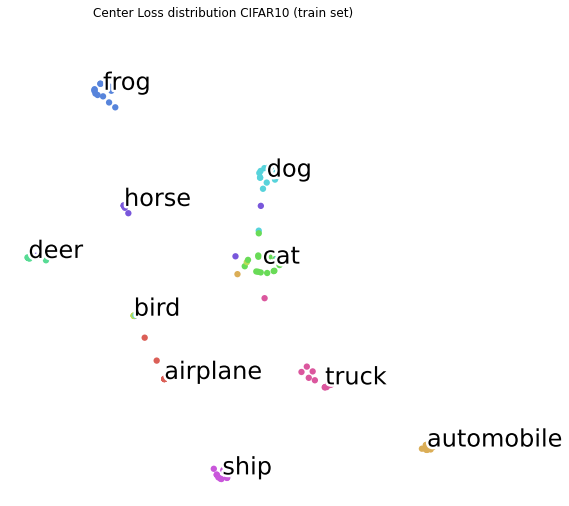

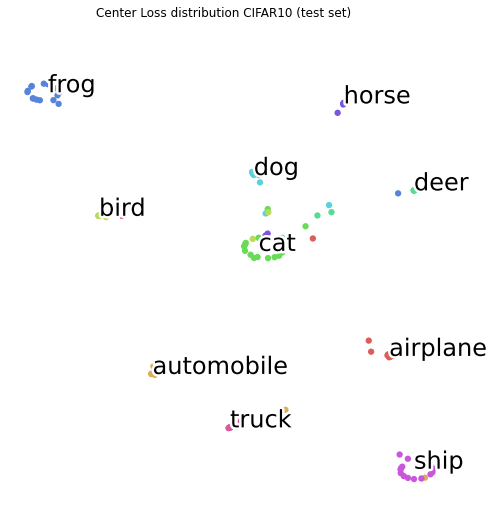

In [26]:
train_outputs = model(torch.tensor(x_train).reshape(128,3,32,32).to(device))
test_outputs = model(torch.tensor(x_test).reshape(128,3,32,32).to(device))
train_tsne_embeds = tsne.fit_transform(train_outputs.cpu().detach().numpy())
test_tsne_embeds = tsne.fit_transform(test_outputs.cpu().detach().numpy())

scatter(train_tsne_embeds, y_train, subtitle=f'Center Loss distribution CIFAR10 (train set)', idx2name=idx2name)
scatter(test_tsne_embeds, y_test, subtitle=f'Center Loss distribution CIFAR10 (test set)', idx2name=idx2name)

In [27]:
def fe(loader, model):
    model.eval()
    features_list = []
    labels_list = []
    for idx, (images, labels) in enumerate(loader):

        images = images.to(device, non_blocking=True)

        with torch.no_grad():
            features = model(images)

        features_list.append(features.cpu())
        labels_list.append(labels.cpu())
  

    return torch.cat(features_list), torch.cat(labels_list)

In [28]:
train_loader_for_fe = DataLoader(CIFAR10('./CIFAR10/', train=True, download=True,
                                transform=transform_test
                               ),batch_size=batch_size_train, shuffle=True,num_workers=num_workers,)
test_loader_for_fe = DataLoader(CIFAR10('./CIFAR10/', train=False, download=True,
                                transform=transform_test
                               ),batch_size=batch_size_train, shuffle=False,num_workers=num_workers)

train_features, train_labels = fe(train_loader_for_fe,model)
valid_features, valid_labels = fe(test_loader_for_fe,model)

Files already downloaded and verified
Files already downloaded and verified


In [29]:
from sklearn.neighbors import KNeighborsClassifier

for n in [2,5,10,20,30,40,50,60,70,80,90,100,150,300]:
    neigh_full = KNeighborsClassifier(n_neighbors=n)

    neigh_full.fit(train_features.numpy(), train_labels.numpy())
    knn_512_res = neigh_full.predict_proba(valid_features.numpy())
    knn_512 = (knn_512_res.argmax(1) == valid_labels.numpy()).sum() / len(valid_labels)
    print(knn_512,n)


0.946 2
0.9472 5
0.9472 10
0.9471 20
0.9472 30
0.9469 40
0.9469 50
0.947 60
0.947 70
0.947 80
0.947 90
0.947 100
0.947 150
0.947 300


In [39]:
n_neighbors = 10

neigh_full = KNeighborsClassifier(n_neighbors=40)

neigh_full.fit(train_features.numpy(), train_labels.numpy())
knn_512_res = neigh_full.predict_proba(valid_features.numpy())

In [40]:
trs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95]
knn_full_res = []
res_tr_dict_full = dict()
num_of_passed_dict_full = dict()
for tr in trs:
        idxs = knn_512_res.max(1)> tr
        num_of_passed_dict_full[tr] = (idxs.sum() / len(valid_labels))
        res_tr_dict_full[tr] = ((knn_512_res[idxs].argmax(1) == valid_labels.numpy()[idxs]).sum() / len(valid_labels.numpy()[idxs]))


In [30]:
classifier.eval()
with torch.no_grad():
    classifier_results_valid = classifier(valid_features.to(device))

In [31]:
fc_results = (classifier_results_valid.softmax(dim=1).max(dim=1)[1].cpu() == valid_labels).sum() / len(valid_labels)

In [32]:
fc_results

tensor(0.9469)

In [41]:
from sklearn.random_projection import SparseRandomProjection
rng = np.random.RandomState(42)
trs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95]
res = []
res_tr_dict = {}
num_of_passed_dict = {}
for comp in [256,128,64,32,16,4,2]:
    sp = SparseRandomProjection(n_components = comp,random_state=rng)
    X = sp.fit_transform(train_features.numpy())

    neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    neigh.fit(X, train_labels.numpy())
    TEST = sp.transform(valid_features.numpy())
    valid_res = neigh.predict_proba(TEST)
    res.append((valid_res.argmax(1) == valid_labels.numpy()).sum() / len(valid_labels))
    res_tr_dict[comp] = dict()
    num_of_passed_dict[comp] = dict()
    for tr in trs:
        idxs = valid_res.max(1)> tr
        num_of_passed_dict[comp][tr] = (idxs.sum() / len(valid_labels))
        res_tr_dict[comp][tr] = ((valid_res[idxs].argmax(1) == valid_labels.numpy()[idxs]).sum() / len(valid_labels.numpy()[idxs]))


In [42]:
s_c = classifier_results_valid.softmax(dim=1)
cls_results = dict()
cls_per = dict()
for tr in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95]:
    idxs = s_c.max(dim=1)[0] > tr
    cls_results[tr] = (s_c[idxs].max(dim=1)[1].cpu() == valid_labels[idxs.cpu()]).sum() / len(valid_labels[idxs.cpu()])
    cls_per[tr] = (sum(idxs) / len(valid_labels)).item()

In [43]:
from sklearn.decomposition import PCA
rng = np.random.RandomState(42)
trs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95]
res_pca = []
res_tr_dict_pca = {}
num_of_passed_dict_pca = {}
for comp in [256,128,64,32,16,4,2]:
    sp = PCA(n_components = comp,random_state=rng)
    X = sp.fit_transform(train_features.numpy())

    neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    neigh.fit(X, train_labels.numpy())
    TEST = sp.transform(valid_features.numpy())
    valid_res = neigh.predict_proba(TEST)
    res_pca.append((valid_res.argmax(1) == valid_labels.numpy()).sum() / len(valid_labels))
    res_tr_dict_pca[comp] = dict()
    num_of_passed_dict_pca[comp] = dict()
    for tr in trs:
        idxs = valid_res.max(1)> tr
        num_of_passed_dict_pca[comp][tr] = (idxs.sum() / len(valid_labels))
        res_tr_dict_pca[comp][tr] = ((valid_res[idxs].argmax(1) == valid_labels.numpy()[idxs]).sum() / len(valid_labels.numpy()[idxs]))


In [33]:
from torch import nn
from torch import optim
import math

In [34]:
class Autoencoder(nn.Module):
    def __init__(self, in_shape, enc_shape):
        super(Autoencoder, self).__init__()
        
        self.encode = nn.Sequential(
            nn.Linear(in_shape, 256),
        )
        depth = [2**i for i in range(int(math.log2(128)),int(math.log2(enc_shape))-1,-1)]
        last = 256
        for d in depth:
            self.encode.extend([
                nn.ReLU(True),
                nn.Dropout(0.2),
                nn.Linear(last, d)
            ])
            last = d
        
        self.decode = nn.Sequential(
            nn.BatchNorm1d(enc_shape)
        )
        depth = [2**i for i in range(int(math.log2(256)),int(math.log2(enc_shape))-1,-1)]
        depth.reverse()
        for d in depth[1:]:
            self.decode.extend([
                nn.Linear(last, d),
                nn.ReLU(True),
                nn.Dropout(0.2),
            ])
            last = d
        
        self.decode.append(nn.Linear(last, in_shape))
        
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x
    

In [35]:
def train(model, error, optimizer, n_epochs, x):
    model.train()
    for epoch in range(1, n_epochs + 1):
        optimizer.zero_grad()
        output = model(x)
        loss = error(output, x)
        loss.backward()
        optimizer.step()
        
        if epoch % int(0.1*n_epochs) == 0:
            print(f'epoch {epoch} \t Loss: {loss.item():.4g}')

In [36]:
models_encoder = dict()
train_data = train_features.clone().to(device)
for dim in [256,128,64,32,16,4,2]:
    encoder = Autoencoder(in_shape=512, enc_shape=dim).to(device)
    #print(encoder)
    error = nn.MSELoss()

    optimizer = optim.Adam(encoder.parameters())

    train(encoder, error, optimizer, 5000, train_data )
    
    models_encoder[dim] = encoder.to("cpu").encode.state_dict()
    del encoder
    del optimizer

epoch 500 	 Loss: 2.72e-05
epoch 1000 	 Loss: 2.091e-05
epoch 1500 	 Loss: 1.653e-05
epoch 2000 	 Loss: 1.932e-05
epoch 2500 	 Loss: 2.535e-05
epoch 3000 	 Loss: 1.093e-05
epoch 3500 	 Loss: 1.372e-05
epoch 4000 	 Loss: 2.849e-05
epoch 4500 	 Loss: 1.801e-05
epoch 5000 	 Loss: 1.842e-05
epoch 500 	 Loss: 0.0002659
epoch 1000 	 Loss: 0.0001624
epoch 1500 	 Loss: 0.0001262
epoch 2000 	 Loss: 0.0001091
epoch 2500 	 Loss: 9.635e-05
epoch 3000 	 Loss: 9.69e-05
epoch 3500 	 Loss: 8.931e-05
epoch 4000 	 Loss: 8.489e-05
epoch 4500 	 Loss: 8.15e-05
epoch 5000 	 Loss: 8.212e-05
epoch 500 	 Loss: 0.0002401
epoch 1000 	 Loss: 0.0001547
epoch 1500 	 Loss: 0.0001263
epoch 2000 	 Loss: 0.0001126
epoch 2500 	 Loss: 0.0001059
epoch 3000 	 Loss: 0.0001013
epoch 3500 	 Loss: 9.899e-05
epoch 4000 	 Loss: 9.805e-05
epoch 4500 	 Loss: 9.546e-05
epoch 5000 	 Loss: 9.511e-05
epoch 500 	 Loss: 0.0001924
epoch 1000 	 Loss: 0.0001331
epoch 1500 	 Loss: 0.0001148
epoch 2000 	 Loss: 0.0001044
epoch 2500 	 Loss: 9.

In [37]:
torch.save(models_encoder,'./autoencoders_cifar10_centerloss.pickle')

In [38]:
autoencoder_featres_train = dict()
autoencoder_featres_valid = dict()
for dim in [256,128,64,32,16,4,2]:
    encoder = Autoencoder(in_shape=512, enc_shape=dim).encode
    encoder.load_state_dict(models_encoder[dim])
    encoder.eval()
    with torch.no_grad():
        autoencoder_featres_train[dim] = encoder(train_data.cpu()).cpu()
        autoencoder_featres_valid[dim] = encoder(valid_features.clone()).cpu()

In [44]:
trs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95]
res_autoencoder = []
res_tr_dict_autoencoder = {}
num_of_passed_dict_autoencoder = {}
for comp in [256,128,64,32,16,4,2]:

    neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    neigh.fit(autoencoder_featres_train[comp].numpy(), train_labels.numpy())
    TEST = autoencoder_featres_valid[comp].numpy()
    valid_res = neigh.predict_proba(TEST)
    res_autoencoder.append((valid_res.argmax(1) == valid_labels.numpy()).sum() / len(valid_labels))
    res_tr_dict_autoencoder[comp] = dict()
    num_of_passed_dict_autoencoder[comp] = dict()
    for tr in trs:
        idxs = valid_res.max(1)> tr
        num_of_passed_dict_autoencoder[comp][tr] = (idxs.sum() / len(valid_labels))
        res_tr_dict_autoencoder[comp][tr] = ((valid_res[idxs].argmax(1) == valid_labels.numpy()[idxs]).sum() / len(valid_labels.numpy()[idxs]))


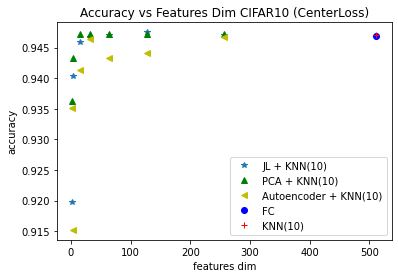

In [59]:
plt.plot([256,128,64,32,16,4,2],res,'*',label=f"JL + KNN({n_neighbors})")
plt.plot([256,128,64,32,16,4,2],res_pca,'g^',label=f"PCA + KNN({n_neighbors})")
plt.plot([256,128,64,32,16,4,2],res_autoencoder,'y<',label=f"Autoencoder + KNN({n_neighbors})")
plt.plot([512,],fc_results,'bo',label="FC")
plt.plot([512,],[knn_512,],'r+',label=f"KNN({n_neighbors})")
plt.title("Accuracy vs Features Dim CIFAR10 (CenterLoss)")
plt.xlabel("features dim")
plt.ylabel("accuracy")
plt.legend()
plt.show()

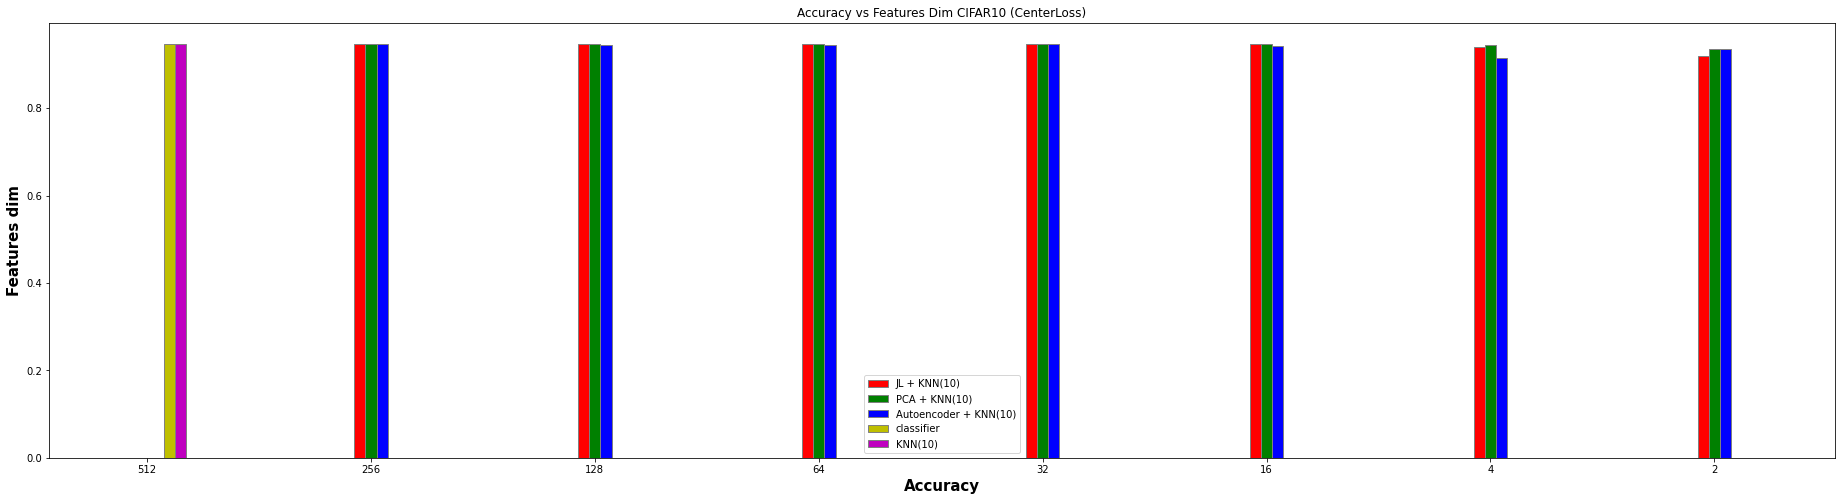

In [58]:
# set width of bar
barWidth = 0.05
fig = plt.subplots(figsize =(32, 8))

 
# Set position of bar on X axis
br1 = np.arange(len(res)+1)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]

# Make the plot
plt.bar(br1, [0,]+res, color ='r', width = barWidth,
        edgecolor ='grey', label=f"JL + KNN({n_neighbors})")
plt.bar(br2, [0,]+res_pca, color ='g', width = barWidth,
        edgecolor ='grey', label =f"PCA + KNN({n_neighbors})")
plt.bar(br3, [0,]+res_autoencoder, color ='b', width = barWidth,
        edgecolor ='grey', label =f"Autoencoder + KNN({n_neighbors})")
plt.bar(br4, [fc_results.tolist(),]+[0,]*len(res), color ='y', width = barWidth,
        edgecolor ='grey', label =f"classifier")
plt.bar(br5, [knn_512,]+[0,]*len(res), color ='m', width = barWidth,
        edgecolor ='grey', label =f"KNN({n_neighbors})")
 
# Adding Xticks
plt.title("Accuracy vs Features Dim CIFAR10 (CenterLoss)")
plt.xlabel('Accuracy', fontweight ='bold', fontsize = 15)
plt.ylabel('Features dim', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len([512,256,128,64,32,16,4,2]))],
        [512,256,128,64,32,16,4,2])
 
plt.legend()
plt.show()

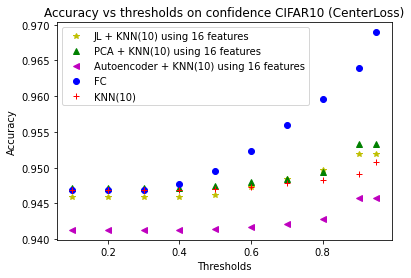

In [57]:
plt.plot(trs,res_tr_dict[16].values(),'y*',label=f"JL + KNN({n_neighbors}) using 16 features ")
plt.plot(trs,res_tr_dict_pca[16].values(),'g^',label=f"PCA + KNN({n_neighbors}) using 16 features")
plt.plot(trs,res_tr_dict_autoencoder[16].values(),'m<',label=f"Autoencoder + KNN({n_neighbors}) using 16 features")
plt.plot(trs,list(cls_results.values()),'bo',label="FC")
plt.plot(trs,list(res_tr_dict_full.values()),'r+',label=f"KNN({n_neighbors})")
plt.title("Accuracy vs thresholds on confidence CIFAR10 (CenterLoss)")
plt.xlabel("Thresholds")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

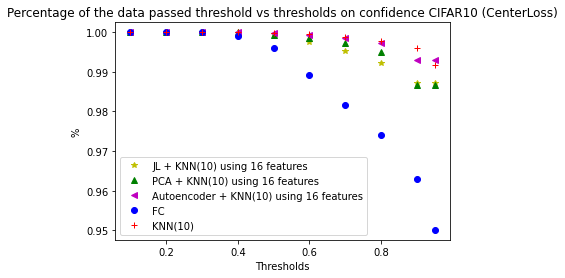

In [56]:
plt.plot(trs,num_of_passed_dict[16].values(),'y*',label=f"JL + KNN({n_neighbors}) using 16 features ")
plt.plot(trs,num_of_passed_dict_pca[16].values(),'g^',label=f"PCA + KNN({n_neighbors}) using 16 features")
plt.plot(trs,num_of_passed_dict_autoencoder[16].values(),'m<',label=f"Autoencoder + KNN({n_neighbors}) using 16 features")
plt.plot(trs,cls_per.values(),'bo',label="FC")
plt.plot(trs,num_of_passed_dict_full.values(),'r+',label=f"KNN({n_neighbors})")
plt.title("Percentage of the data passed threshold vs thresholds on confidence CIFAR10 (CenterLoss)")
plt.xlabel("Thresholds")
plt.ylabel("%")
plt.legend()
plt.show()